## Preprocessing using glove embedding

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
import gensim.downloader as api

# Load GloVe model with Gensim's API
embeddings_model = api.load("glove-twitter-200")  # 200-dimensional GloVe embeddings

# Read all training files and concatenate them into one dataframe
li = []
for filename in tqdm(os.listdir("train_tweets")):
    df = pd.read_csv("train_tweets/" + filename)
    li.append(df)
df = pd.concat(li, ignore_index=True)
df = df.sample(n=500000, random_state=42)

In [ ]:
from challenge_data.glove_nn import preprocess_text, get_avg_embedding
import numpy as np
from sklearn.model_selection import train_test_split
from challenge_data.glove_nn import compute_mean_and_max_concat
from textblob import TextBlob

# Apply preprocessing to each tweet
df['Tweet'] = df['Tweet'].apply(preprocess_text)

# Add a feature for sentiment using TextBlob, after preprocesing
df['sentiment'] = df['Tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Apply preprocessing to each tweet and obtain vectors
vector_size = 200  # Adjust based on the chosen GloVe model

df['Embeddings'] = list(np.vstack([get_avg_embedding(tweet, embeddings_model, vector_size) for tweet in df['Tweet']]))

# Remove rows with NaN embedding vectors
df.dropna(inplace=True)

# Drop the columns that are not useful anymore
df = df.drop(columns=['Timestamp', 'Tweet'])

# Drop the columns that are not useful anymore
period_features = df.groupby(['MatchID', 'PeriodID', 'ID']).mean().reset_index()

# Recreate X and y
X = np.hstack([
    np.vstack(period_features['Embeddings']),
    period_features['PeriodID'].values.reshape(-1, 1),
    period_features['sentiment'].values.reshape(-1, 1)
])
y = period_features['EventType'].values

# Ensure X and y have the same length
print("Length of X:", len(X))
print("Length of y:", len(y))

# We split our data into a training and test set that we can use to train our classifier without fine-tuning into the
# validation set and without submitting too many times into Kaggle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Length of X: 2137
Length of y: 2137


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create a dataset and data loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## The neural network

In [ ]:
import importlib
import torch.nn as nn
import torch.optim as optim
import challenge_data.glove_nn
importlib.reload(challenge_data.glove_nn)
from challenge_data.glove_nn import NeuralNet, train

# Hyperparameters
lr = 0.01
num_epochs = 200
slope = 0.01
model = NeuralNet(input_size=vector_size+2, slope=slope)
criterion = nn.BCEWithLogitsLoss(reduction="mean", pos_weight=torch.tensor([1.0, 5.0]))  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


NameError: name 'vector_size' is not defined

In [ ]:
from sklearn.metrics import accuracy_score

# Training
loss_list = train(num_epochs, model, train_loader, criterion, optimizer, scheduler)

# Evaluation on the test set
model.eval()
with torch.no_grad():
    y_pred_list = []
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        y_pred_list.extend(outputs.numpy())

y_pred = (np.array(y_pred_list) > 0.5).astype(int)  # Adjust threshold for binary classification

# Print test set accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)

100%|█████████████████████████████████████████████████████████████| 200/200 [01:20<00:00,  2.49it/s]

Test set accuracy: 0.7258566978193146


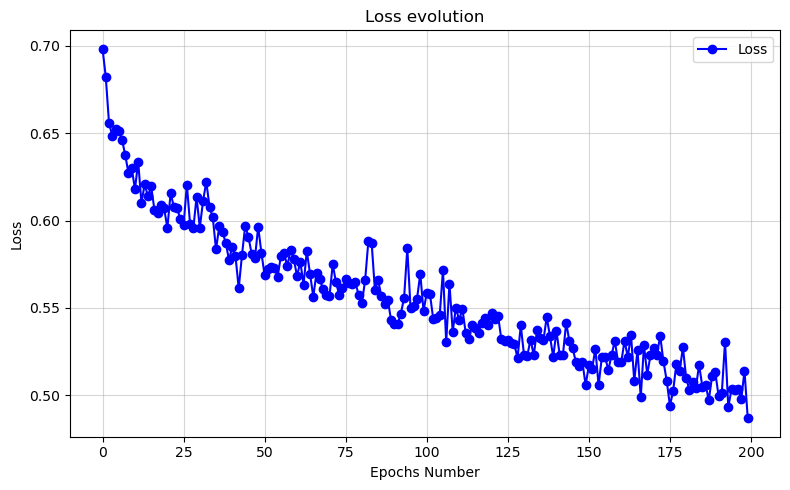

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_list, marker='o', linestyle='-', color='b', label='Loss')
plt.title("Loss evolution")
plt.xlabel("Epochs Number")
plt.ylabel("Loss")
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()